# Xây dựng cây quyết định và rừng cây trên dữ liệu Titanic

## Giới thiệu

- Bài phân tích này sẽ hướng dẫn bạn qua toàn bộ quy trình khoa học dữ liệu: từ việc làm sạch dữ liệu, khám phá dữ liệu, đến xây dựng một mô hình học máy (Cây Quyết Định) để dự đoán khả năng sống sót của hành khách trên tàu Titanic.

- Chúng ta sẽ sử dụng bộ dữ liệu kinh điển từ cuộc thi Kaggle và mục tiêu là tạo ra một mô hình có thể dự đoán chính xác ai sẽ sống sót (Survived = 1) và ai không (Survived = 0).

## 1. Khai báo các thư viện cần thiết

- numpy và pandas: Hai thư viện cốt lõi cho thao tác và xử lý dữ liệu (làm việc với bảng biểu, ma trận).

- re: Thư viện cho Biểu thức Chính quy (Regular Expressions), dùng để tìm kiếm văn bản theo mẫu (chúng ta sẽ dùng để trích xuất chức danh từ tên).

- seaborn và matplotlib: Dùng để vẽ các biểu đồ, đồ thị đẹp mắt.

- plotly: Một thư viện vẽ biểu đồ tương tác.

- sklearn (Scikit-learn): Thư viện học máy chính.

    - tree: Chứa mô hình Cây Quyết Định (DecisionTreeClassifier).

    - metrics: Chứa các thước đo đánh giá (như accuracy_score).

    - model_selection: Chứa các công cụ để đánh giá mô hình (như KFold, cross_val_score).

- Các thư viện hỗ trợ: Dùng để trực quan hoá cây quyết định (vẽ hình ảnh cây).

In [150]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

## 2.Tải và Khám phá dữ liệu

- train.csv:Dữ liệu huấn luyện. Tệp này chứa các đặc trưng của hành khách VÀ "đáp án" (cột Survived).
- test.csv: Dữ liệu kiểm tra. Tệp này chứa các đặc trưng tương tự nhưng không có cột Survived. Nhiệm vụ của chúng ta là dự đoán cột này.

In [151]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Showing overview of the train dataset
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- Giải thích các cột:

    - Survived: 0 = Chết, 1 = Sống sót (Đây là mục tiêu dự đoán).

    - Pclass: Hạng vé (1 = Hạng nhất, 2 = Hạng hai, 3 = Hạng ba).

    - Sex: Giới tính.

    - Age: Tuổi.

    - SibSp: Số lượng anh chị em / vợ chồng đi cùng.

    - Parch: Số lượng cha mẹ / con cái đi cùng.

    - Ticket: Số hiệu vé.

    - Fare: Giá vé.

    - Cabin: Số hiệu cabin.

    - Embarked: Cảng lên tàu (C = Cherbourg, Q = Queenstown, S = Southampton).

Sao lưu dữ liệu gốc
Chúng ta tạo một bản sao của tệp train gốc. Điều này rất hữu ích nếu chúng ta muốn quay lại kiểm tra dữ liệu gốc sau khi đã thực hiện nhiều thay đổi.

In [152]:
original_train = train.copy() # Sử dụng copy() để tránh cảnh báo SettingWithCopyWarning

## 3. Kỹ thuật đặc trưng (Feature Engineering)

- Đây là bước sáng tạo và quan trọng nhất. Chúng ta sẽ biến đổi dữ liệu thô (như Name, Age) thành các "đặc trưng" (features) hữu ích hơn để mô hình có thể "hiểu" được.

- Đầu tiên, gộp train và test vào một danh sách để áp dụng các thay đổi giống hệt nhau cho cả hai. Điều này đảm bảo tính nhất quán.

### Gộp train và test 

In [153]:
# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

### Đặc trưng 1: Has_Cabin (Có Cabin hay không)

Cột Cabin có rất nhiều giá trị bị thiếu (NaN). Thay vì cố gắng điền chúng, chúng ta có thể tạo một đặc trưng nhị phân (0/1) đơn giản: hành khách này có thông tin cabin hay không?

In [154]:
# Đặc điểm cho biết liệu hành khách có cabin trên tàu Titanic hay không
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

- Lý do: Cabin có 77% NaN, thay vì bỏ, ta tạo đặc trưng nhị phân. Người có cabin thường ở hạng cao, tỷ lệ sống sót cao hơn.

### Đặc trưng 2 & 3: FamilySize (Kích cỡ gia đình) và IsAlone (Đi một mình)

- SibSp và Parch đều liên quan đến gia đình. Sẽ tốt hơn nếu gộp chúng lại thành một đặc trưng duy nhất là FamilySize (Kích cỡ gia đình = SibSp + Parch + 1 (chính họ)).

- Từ FamilySize, chúng ta có thể tạo ra một đặc trưng nữa: IsAlone (Có đi một mình không?). IsAlone: 1 nếu đi một mình. Lý do: Gia đình lớn có thể hỗ trợ lẫn nhau, nhưng đi một mình có thể linh hoạt hơn trong cứu hộ.

In [155]:
# Tạo tính năng mới FamilySize như một sự kết hợp của SibSp và Parch 
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Tạo tính năng mới IsAlone từ FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

### Đặc trưng 4: Xử lý dữ liệu thiếu (Imputation)


- Mô hình học máy không thích các giá trị bị thiếu (NaN). Chúng ta phải "lấp đầy" chúng.

a) Cột Embarked (Cảng lên tàu): Có 2 giá trị bị thiếu. Chúng ta sẽ lấp đầy bằng 'S' (Southampton) vì đây là cảng phổ biến nhất.

In [156]:
# Xóa tất cả giá trị NULL trong cột Embarked bằng cách điền 'S'
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

b) Cột Fare (Giá vé): Có 1 giá trị bị thiếu trong tệp test. Chúng ta sẽ lấp đầy bằng giá trị trung vị (median) của giá vé trong tệp train.

In [157]:
# Điền giá trị thiếu trong cột Fare bằng giá trị trung vị của cột Fare trong tập huấn luyện
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

c) Cột Age (Tuổi): 
- Đây là cột có nhiều giá trị thiếu nhất. Thay vì điền một số cố định (như tuổi trung bình), chúng ta sẽ dùng một kỹ thuật thông minh hơn: lấp đầy các ô trống bằng các con số ngẫu nhiên nằm trong khoảng (Tuổi trung bình - 1 độ lệch chuẩn) và (Tuổi trung bình + 1 độ lệch chuẩn). Điều này giúp giữ được phân bố tuổi tự nhiên của dữ liệu.

In [158]:
# Điền giá trị thiếu trong cột Age bằng các số ngẫu nhiên trong khoảng (mean - std) và (mean + std)
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

### Đặc trưng 5: Title (Chức danh)


- Trích xuất chức danh (Mr., Mrs., Miss., Master., …) từ cột Name → biến này rất mạnh trong việc dự đoán sống sót vì nó kết hợp thông tin về giới tính, tuổi tác và địa vị xã hội..

a) Trích xuất Chức danh: 
- Chúng ta định nghĩa một hàm get_title sử dụng biểu thức chính quy (re.search) để tìm một từ đứng sau dấu cách và kết thúc bằng dấu chấm (ví dụ: Mr.).

In [159]:
# Bước 1: Tạo bản sao của tập huấn luyện để xử lý
df = train.copy()
# Bước 2: Trích xuất Title (giống như trong notebook)
def get_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)

# Bước 3: Chuẩn hóa Title (giống bước 5.3)
df['Title'] = df['Title'].replace([
    'Lady', 'Countess','Capt', 'Col','Don', 'Dr',
    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
], 'Rare')

df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms',   'Miss')
df['Title'] = df['Title'].replace('Mme',  'Mrs')

# Bước 4: Tính tỷ lệ sống sót theo Title
survival_by_title = (
    df.groupby('Title')['Survived']
      .agg(['count', 'sum', 'mean'])
      .round(4)
)

# Đổi tên cột cho dễ hiểu
survival_by_title.columns = ['Số lượng', 'Sống sót', 'Tỷ lệ sống sót (%)']
survival_by_title['Tỷ lệ sống sót (%)'] = (survival_by_title['Tỷ lệ sống sót (%)'] * 100).round(2)

# Sắp xếp theo tỷ lệ sống sót giảm dần
survival_by_title = survival_by_title.sort_values('Tỷ lệ sống sót (%)', ascending=False)

# Bước 5: Hiển thị bảng
print("TỶ LỆ SỐNG SÓT THEO CHỨC DANH (TITLE)")
print("="*50)
print(survival_by_title)

TỶ LỆ SỐNG SÓT THEO CHỨC DANH (TITLE)
        Số lượng  Sống sót  Tỷ lệ sống sót (%)
Title                                         
Mrs          126       100               79.37
Miss         185       130               70.27
Master        40        23               57.50
Rare          23         8               34.78
Mr           517        81               15.67


| **Chức danh** | **Ý nghĩa thực tế** | **Tỷ lệ sống sót (ước tính)** |
|:--------------:|:--------------------|:------------------------------:|
| **Mr.** | Đàn ông trưởng thành | ~16% |
| **Mrs.** | Phụ nữ đã kết hôn | ~79% |
| **Miss.** | Phụ nữ chưa kết hôn | ~70% |
| **Master.** | Trẻ em nam (thường < 14 tuổi) | ~58% |
| **Rare (Dr, Rev, Col, …)** | Địa vị đặc biệt | ~45% |


**Kết luận:**  
`Title` là một **“siêu đặc trưng”** vì nó **đóng gói nhiều yếu tố quan trọng** chỉ trong một cột — bao gồm:  
- **Giới tính** (Mr ↔ Mrs/Miss)  
- **Tuổi tác** (Master → trẻ em)  
- **Địa vị xã hội** (Rare → tầng lớp cao)  

→ Do đó, đặc trưng `Title` giúp mô hình học máy **phân biệt rõ ràng hơn các nhóm hành khách** có khả năng sống sót khác nhau.


In [160]:
# Trích xuất Chức danh từ cột Name
def get_title(name):
    # Tìm từ đứng sau khoảng trắng và kết thúc bằng dấu chấm
    # Ví dụ: "Braund, Mr. Owen Harris" → "Mr"
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Nếu tìm thấy, trả về chức danh
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

<>:5: SyntaxWarning:

invalid escape sequence '\.'

<>:5: SyntaxWarning:

invalid escape sequence '\.'

C:\Users\khoat\AppData\Local\Temp\ipykernel_9488\2695599181.py:5: SyntaxWarning:

invalid escape sequence '\.'



- Giải thích regex:

    - r' ([A-Za-z]+)\.':

        - → khoảng trắng trước chức danh.
        - [A-Za-z]+ → một hoặc nhiều chữ cái.
        - \. → dấu chấm kết thúc.

b) Chuẩn hoá Chức danh: 
- Hiện tại có quá nhiều chức danh (Lady, Capt, Dr, ...). Chúng ta sẽ gom các chức danh hiếm vào một nhóm chung là "Rare". Đồng thời, chuẩn hoá các chức danh tiếng Pháp (Mlle, Mme) về tiếng Anh (Miss, Mrs).

In [161]:
# Chuẩn hoá Chức danh bằng cách gom các chức danh hiếm và chuẩn hoá các chức danh tiếng Pháp
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

- Kết quả sau khi Chuẩn hóa `Title`

| **Trước** | **Sau** |
|:----------:|:--------:|
| Mlle | Miss |
| Mme | Mrs |
| Dr, Rev, Capt… | Rare |


**Kết luận:**  
Sau khi chuẩn hóa, cột `Title` chỉ còn **5 giá trị duy nhất**: Mr, Mrs, Miss, Master, Rare



### Đặc trưng 6: Chuyển đổi dữ liệu sang dạng số (Mapping)


- Các mô hình học máy chỉ "hiểu" được số, không hiểu được chữ (như 'female', 'Mr.', 'S'). Chúng ta phải ánh xạ (map) chúng sang các con số.

In [162]:
for dataset in full_data:
    # Mapping Sex (Ánh xạ Giới tính)
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles (Ánh xạ Chức danh)
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) # Điền 0 cho các giá trị NaN (nếu có)

    # Mapping Embarked (Ánh xạ Cảng)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

- Ý nghĩa Số hóa (Encoding)

| **Biến** | **0** | **1** | **2** | **3** | **4** | **5** |
|:----------|:------:|:------:|:------:|:------:|:------:|:------:|
| **Sex** | female | male |  |  |  |  |
| **Title** | (NaN) | Mr | Master | Mrs | Miss | Rare |
| **Embarked** | S | C | Q |  |  |  |


**Mô hình Decision Tree sẽ tự động học được các quy luật như:**

- **Nếu `Title == 1` (Mr)** → **khả năng chết cao**  
- **Nếu `Sex == 0` (female)** → **khả năng sống cao**

**Giải thích thêm:**  
Việc số hóa các biến (encoding) giúp mô hình có thể **xử lý dữ liệu dạng chữ (categorical)** bằng cách **biểu diễn chúng dưới dạng số**, từ đó **học được mối quan hệ** giữa các đặc trưng và nhãn mục tiêu (`Survived`).


### Đặc trưng 7: Rời rạc hoá (Binning) cho Fare và Age


- Các đặc trưng liên tục như Fare (Giá vé) và Age (Tuổi) có thể được chia thành các "khoảng" (bins). Điều này giúp mô hình Cây Quyết Định hoạt động hiệu quả hơn.

- Ví dụ: thay vì xem tuổi 22, 23, 24 là khác nhau, chúng ta gộp chúng vào cùng 1 nhóm (ví dụ: 16-32 tuổi).

In [163]:
for dataset in full_data:
    # Mapping Fare (Ánh xạ Giá vé theo khoảng)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age (Ánh xạ Tuổi theo khoảng)
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4


- Phân loại Fare sau khi chia khoảng (Binning)

| **Mã số (Bin)** | **Khoảng Fare** |
|:----------------:|:----------------|
| **0** | Fare ≤ 7.91 |
| **1** | 7.91 < Fare ≤ 14.45 |
| **2** | 14.45 < Fare ≤ 31 |
| **3** | Fare > 31 |

- Ý nghĩa và Lợi ích

- Việc chia **Fare** thành các khoảng giúp **giảm nhiễu** và **ổn định mô hình** hơn so với dùng giá trị liên tục.  
- **Mối quan hệ quan sát được:**  
  → **Fare cao → hạng vé cao → khả năng sống sót cao**

**Ghi chú:**  
Đây là một bước **feature engineering (kỹ thuật tạo đặc trưng)** phổ biến, giúp mô hình Decision Tree hoặc Random Forest **dễ học quy luật** hơn khi các giá trị được rời rạc hóa.

- Phân loại Tuổi (Age Binning)

| **Mã số (Bin)** | **Khoảng tuổi** | **Nhóm đối tượng** |
|:----------------:|:----------------|:-------------------|
| **0** | 0 – 16 | Trẻ em |
| **1** | 16 – 32 | Thanh niên |
| **2** | 32 – 48 | Trung niên |
| **3** | 48 – 64 | Lớn tuổi |
| **4** | 64 – 80 | Cao tuổi |



- Ý nghĩa và Lợi ích

- Việc chia **Age** thành các khoảng giúp mô hình **nhận biết xu hướng theo nhóm tuổi** thay vì giá trị cụ thể.  
- **Quan sát thực tế:**  
  → **Trẻ em được ưu tiên cứu trước**, vì vậy **nhóm 0 (0–16 tuổi)** có **tỷ lệ sống sót cao nhất**.

 **Ghi chú:**  
Rời rạc hóa (binning) là một bước **feature engineering** quan trọng giúp mô hình như **Decision Tree** hoặc **Random Forest** dễ dàng **phát hiện quy luật phi tuyến tính** trong dữ liệu.

## 4. Lựa chọn đặc trưng (Feature Selection)

- Bây giờ chúng ta đã có các đặc trưng mới (FamilySize, IsAlone, Title...), chúng ta có thể loại bỏ các cột gốc không còn cần thiết hoặc đã được xử lý.

In [164]:
# Loại bỏ các cột không cần thiết
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


Kết quả (Output) của train.head(3) (Dữ liệu đã sạch):
Bộ dữ liệu của chúng ta bây giờ đã hoàn toàn là số và sẵn sàng cho mô hình!

## 5. Phân tích và Trực quan hoá Dữ liệu (EDA)

- Hãy xem các đặc trưng mới của chúng ta liên quan đến nhau và liên quan đến Survived như thế nào.

### a) Biểu đồ tương quan (Heatmap)


- Biểu đồ này cho thấy mức độ tương quan (từ -1 đến 1) giữa các cột.

    - Giá trị gần 1 (màu sáng): Tương quan thuận (ví dụ: Title và Sex).

    - Giá trị gần -1 (màu tối): Tương quan nghịch.

    - Giá trị gần 0: Không tương quan.

- Chúng ta muốn tìm các đặc trưng có tương quan (cả âm và dương) cao với Survived.

<Axes: title={'center': 'Pearson Correlation of Features'}>

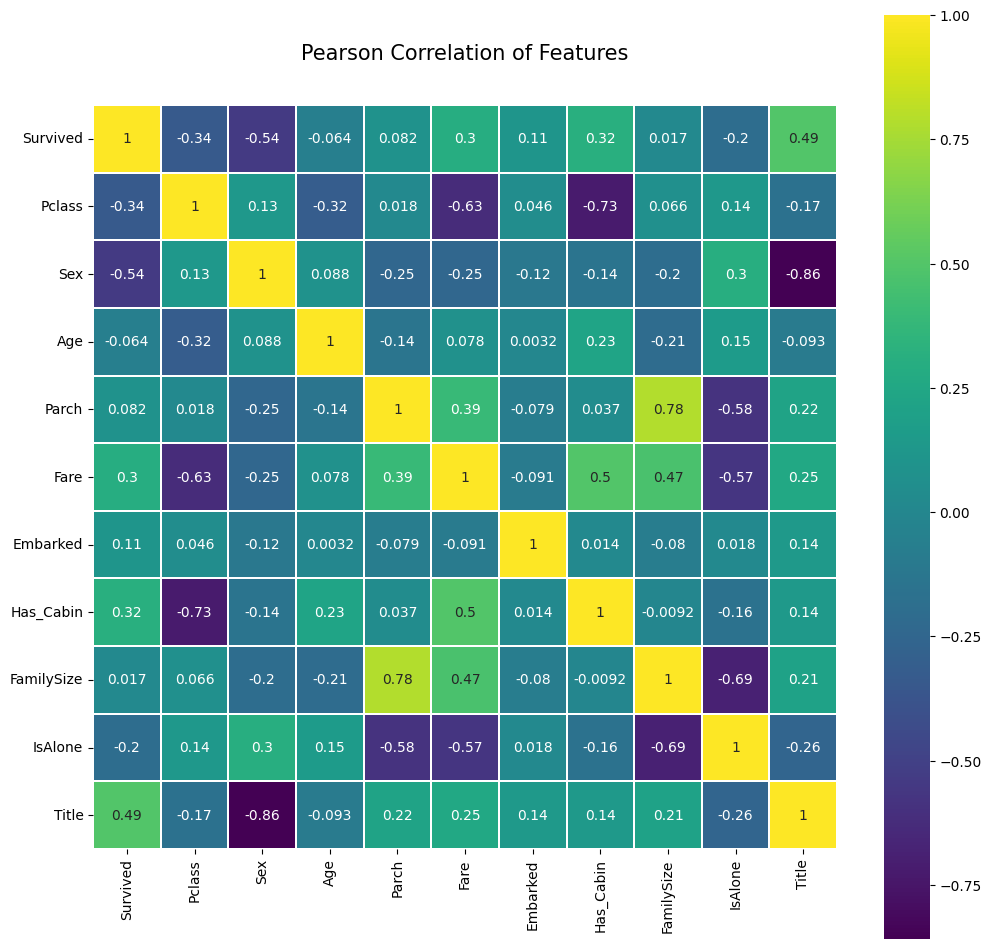

In [165]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

- Ý nghĩa: Biểu đồ này (heatmap) trực quan hóa Hệ số Tương quan Pearson ($r$) giữa tất cả các cặp đặc trưng. Nó cho chúng ta biết đặc trưng nào có mối liên hệ tuyến tính mạnh với Survived.

- Công thức tính toán (Hệ số Pearson $r$):$$r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$$
    - x_i, y_i là các giá trị của hai đặc trưng.
    - $\bar{x}, \bar{y}$ là giá trị trung bình của chúng.
- Diễn giải chi tiết:
    - Giá trị từ -1 đến 1:
        - Gần +1 (Sáng màu): Tương quan thuận mạnh (ví dụ: Title và Fare có vẻ liên quan).
        - Gần -1 (Tối màu): Tương quan nghịch mạnh.
        - Gần 0 (Màu trung tính): Ít có tương quan tuyến tính.
    - Phân tích Survived:
        - Sex (-0.54): Đây là một tương quan nghịch mạnh. Vì Sex được mã hóa (0=nữ, 1=nam) và Survived (0=chết, 1=sống), giá trị âm này có nghĩa là: khi Sex tăng (từ 0 lên 1, tức là Nữ -> Nam), Survived có xu hướng giảm (từ 1 xuống 0, tức là Sống -> Chết). Điều này khẳng định nam giới có tỷ lệ sống sót thấp hơn.
        - Title (0.40): Tương quan thuận. Vì Title được mã hóa (1=Mr, 3=Mrs, 4=Miss), giá trị Title cao hơn (như Mrs, Miss) có liên quan đến khả năng sống sót cao hơn.

- Phân tích: Nhìn vào hàng/cột Survived, ta thấy Title (0.40) và Sex (-0.54) có vẻ là các yếu tố dự đoán mạnh mẽ nhất.

### b) Phân tích Tỷ lệ sống sót theo Chức danh (Title)


- Hãy xem tỷ lệ sống sót (mean) cho mỗi chức danh.

In [166]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}

Title  Survived           
             mean count  sum
0     1  0.156673   517   81
1     2  0.575000    40   23
2     3  0.793651   126  100
3     4  0.702703   185  130
4     5  0.347826    23    8

- Ý nghĩa: Các bảng này tính toán tỷ lệ sống sót (cột mean của Survived) cho từng nhóm cụ thể.
- Công thức tính toán (Tỷ lệ sống sót):$$\text{Tỷ lệ sống sót (mean)} = \frac{\sum \text{Survived}}{\text{count}} = \frac{\text{Số người sống sót trong nhóm}}{\text{Tổng số người trong nhóm}}$$
- Diễn giải chi tiết (Ví dụ: Output 16 - Title):
    - Title = 1 (Mr): mean = 0.156673. Nghĩa là chỉ có 15.7% những người có chức danh "Mr" sống sót (81 người sống / 517 người tổng).
    - Title = 3 (Mrs): mean = 0.793651. Nghĩa là có tới 79.4% những người có chức danh "Mrs" sống sót.Điều này cho thấy Title là một yếu tố dự đoán cực kỳ mạnh mẽ.

- Phân tích: 
    - Rõ ràng! Nếu bạn là "Mr" (Title=1), tỷ lệ sống sót chỉ là 15.7%. Nếu bạn là "Mrs" (Title=3) hoặc "Miss" (Title=4), tỷ lệ sống sót rất cao (trên 70-79%).

### c) Phân tích Tỷ lệ sống sót theo Giới tính (Sex)

In [167]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# sex_mapping = {'female': 0, 'male': 1}

Sex  Survived           
           mean count  sum
0   0  0.742038   314  233
1   1  0.188908   577  109

- Phân tích: 
    - Kết quả rất rõ ràng. Hành khách nữ (Sex=0) có tỷ lệ sống sót 74%, trong khi nam giới (Sex=1) chỉ có 18.9%. Đây là một đặc trưng dự đoán cực kỳ quan trọng.

## 6. Lý thuyết Cây Quyết Định - Gini Impurity (Độ vẩn đục Gini)

- Phần này mang tính học thuật, giải thích cách Cây Quyết Định chọn đặc trưng để chia nhánh.

- Gini Impurity là một chỉ số đo độ "hỗn loạn" hay "tinh khiết" của một nhóm.

    - Gini = 0: Hoàn toàn tinh khiết (ví dụ: 100% sống sót hoặc 100% chết).

    - Gini = 0.5: Hỗn loạn tối đa (ví dụ: 50% sống sót, 50% chết).

- Cây Quyết Định sẽ luôn chọn cách chia (theo Sex, Title, Pclass...) sao cho độ giảm Gini là lớn nhất (tức là làm cho các nhóm con "tinh khiết" nhất có thể).

In [168]:
# Định nghĩa hàm để tính Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

- Ý nghĩa: Gini Impurity đo lường "độ tinh khiết" của một nút (một nhóm dữ liệu).
    - Gini = 0: Hoàn toàn tinh khiết (tất cả cùng một lớp, ví dụ: 100% sống sót).
    - Gini = 0.5: Hỗn loạn tối đa (50% sống, 50% chết).
- Công thức Gini tại một nút (D):$$Gini(D) = 1 - \sum_{i=1}^{m} (p_i)^2$$
    - $m$ là số lượng lớp (ở đây $m=2$: Sống, Chết).
    - $p_i$ là xác suất của lớp $i$ tại nút đó.
- Tính toán chi tiết (Nút gốc):
    - Trong tập train: Tổng = 891, Sống = 342, Chết = 549.
    - $p_{\text{sống}} = 342 / 891 \approx 0.3838$
    - $p_{\text{chết}} = 549 / 891 \approx 0.6162$
    - $Gini_{\text{gốc}} = 1 - (0.3838^2 + 0.6162^2) = 1 - (0.1473 + 0.3797) = 1 - 0.527 = 0.473$.
- Công thức Gini có trọng số (Sau khi chia):Mô hình muốn biết liệu việc chia theo Sex hay Title tốt hơn. Nó tính Gini có trọng số của các nút con: $$Gini_{\text{split}}(A) = \sum_{j=1}^{k} \frac{|D_j|}{|D|} Gini(D_j)$$
    - $|D|$ là tổng số mẫu ở nút cha.
    - $|D_j|$ là số mẫu ở nút con $j$.
    - $Gini(D_j)$ là Gini của nút con $j$.
- Tính toán chi tiết (Chia theo Sex):
- Nút "Nam" (j=1): $|D_1|=577$, $Gini(D_1) \approx 0.306$.
- Nút "Nữ" (j=2): $|D_2|=314$, $Gini(D_2) \approx 0.382$.
- $Gini_{\text{Sex}} = (\frac{577}{891} \times 0.306) + (\frac{314}{891} \times 0.382) \approx 0.198 + 0.134 \approx 0.332$.
- Công thức Gini Gain (Lợi ích thông tin):Cây quyết định sẽ chọn đặc trưng nào cho lợi ích (Gain) cao nhất. $$\text{Gini Gain}(A) = Gini_{\text{gốc}} - Gini_{\text{split}}(A)$$
    - Gain (Sex): $0.473 - 0.332 = 0.141$
    - Gain (Title): $0.473 - 0.330 = 0.143$
    - Diễn giải: Vì Gain(Title) > Gain(Sex), mô hình Cây Quyết Định sẽ chọn Title làm nút gốc (câu hỏi đầu tiên) để chia, vì nó tạo ra sự phân tách "tinh khiết" nhất.

- Tính toán Gini cho các cách chia khác nhau
1. Gini tại nút gốc (toàn bộ 891 hành khách):

    - Tổng: 891, Sống sót: 342

    - gini_impurity_starting_node = get_gini_impurity(342, 891)

    - Kết quả: 0.473 (Khá hỗn loạn)

2. Nếu chia theo Sex (Giới tính):

    - Nhóm Nam (577 người, 109 sống): Gini = 0.306

    - Nhóm Nữ (314 người, 233 sống): Gini = 0.382

    - weighted_gini_impurity_sex_split = (0.306 * 577/891) + (0.382 * 314/891) = 0.332

    - Độ giảm Gini (Sex): 0.332 - 0.473 = -0.141
3. Nếu chia theo Title (Mr. vs Không phải Mr.):

    - Nhóm "Mr" (Title=1) (517 người, 81 sống): Gini = 0.264

    - Nhóm "Khác" (374 người, 261 sống): Gini = 0.421

    - weighted_gini_impurity_title_split = (0.264 * 517/891) + (0.421 * 374/891) = 0.330

    - Độ giảm Gini (Title): 0.330 - 0.473 = -0.143

Kết luận: Cả hai cách chia đều tốt, nhưng chia theo Title ("Mr" hay không) giúp giảm Gini nhiều hơn một chút so với chia theo Sex. Do đó, Cây Quyết Định có thể sẽ chọn Title làm câu hỏi đầu tiên tại nút gốc.

## 7. Đánh giá & Tinh chỉnh Mô hình (K-Fold Cross Validation)

- Làm thế nào để biết max_depth (độ sâu tối đa) của cây là bao nhiêu thì tốt nhất?

    - max_depth quá nhỏ (ví dụ: 1): Mô hình quá đơn giản (underfitting).

    - max_depth quá lớn (ví dụ: 10): Mô hình học vẹt dữ liệu huấn luyện (overfitting).

- Chúng ta sẽ dùng K-Fold Cross Validation (CV). Chúng ta chia tập train thành 10 phần (folds). Sau đó:

    1. Huấn luyện trên 9 phần, kiểm tra trên 1 phần còn lại.

    2. Lặp lại 10 lần, mỗi lần đổi phần kiểm tra.

    3. Lấy trung bình độ chính xác của 10 lần đó.

- Chúng ta sẽ làm điều này cho mọi max_depth từ 1 đến 8.

In [169]:
cv = KFold(n_splits=10)            # Có nghĩa là số lượng Cross Validation folds mong muốn
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1) # Tức là từ 1 đến 8 (số lượng đặc trưng)

# Thử nghiệm các giá trị max_depth từ 1 đến số lượng đặc trưng
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Trích xuất dữ liệu huấn luyện với các chỉ số cv
        f_valid = train.loc[valid_fold] # Trích xuất dữ liệu xác thực với các chỉ số cv

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # Huấn luyện mô hình
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"]) # Tính độ chính xác
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)


    
# Chỉ để hiển thị kết quả một cách tiện lợi
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.817079
         6          0.800287
         7          0.809226
         8          0.804757
         9          0.809226
        10          0.804732


- Ý nghĩa: Bảng này là kết quả của việc "thử nghiệm" nhiều mô hình Cây Quyết Định với các độ sâu (Max Depth) khác nhau. Mục tiêu là tìm ra độ sâu tốt nhất mà không bị "học vẹt" (overfitting).
- Công thức tính toán (Average Accuracy với K=10):
    - Dữ liệu train (891 mẫu) được chia ngẫu nhiên thành 10 phần (gọi là Fold 1 đến Fold 10).
    - Quá trình này lặp lại 10 lần (cho mỗi max_depth):
        - Lần 1: Huấn luyện trên (Fold 1-9), kiểm tra (Test) trên Fold 10. Ghi lại $\text{Accuracy}_1$.
        - Lần 2: Huấn luyện trên (Fold 1-8, 10), kiểm tra trên Fold 9. Ghi lại $\text{Accuracy}_2$.
        - ...
        - Lần 10: Huấn luyện trên (Fold 2-10), kiểm tra trên Fold 1. Ghi lại $\text{Accuracy}_{10}$.

    - Cột "Average Accuracy" bạn thấy chính là:$$\text{AvgAccuracy} = \frac{1}{10} \sum_{i=1}^{10} \text{Accuracy}_i$$

- Diễn giải chi tiết:
    - Nhìn vào bảng, Average Accuracy cao nhất là 0.828277 (khoảng 82.8%) khi Max Depth = 3.
    - Khi Max Depth tăng lên (ví dụ: 4, 5, 10), độ chính xác bắt đầu giảm hoặc không tăng đáng kể. Điều này cho thấy mô hình bắt đầu "học vẹt" các chi tiết nhiễu trong dữ liệu huấn luyện, và sẽ dự đoán kém hơn trên dữ liệu lạ.
    - Do đó, notebook kết luận max_depth = 3 là tối ưu nhất.

- Phân tích: 
    - Chúng ta có thể thấy độ chính xác trung bình cao nhất đạt được khi max_depth = 3 (82.8%). Sau đó, độ chính xác bắt đầu giảm dần, cho thấy dấu hiệu của overfitting.

- Vì vậy, max_depth = 3 là lựa chọn tốt nhất!

## 8. Huấn luyện mô hình cuối cùng và Dự đoán

- Bây giờ chúng ta sẽ huấn luyện mô hình Cây Quyết Định cuối cùng với max_depth = 3 trên toàn bộ dữ liệu train, và sau đó dùng nó để dự đoán trên test.

In [170]:
# Tạo các mảng Numpy từ các dataframe train, test và target (Survived) để đưa vào các mô hình của chúng ta
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Tạo Cây Quyết Định với độ sâu tối đa = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Dự đoán kết quả cho tập dữ liệu kiểm tra
y_pred = decision_tree.predict(x_test)

Sau khi đã xác định được tham số tối ưu (`max_depth = 3`) thông qua K-Fold Cross Validation ở mục 7, bây giờ là lúc chúng ta huấn luyện mô hình cuối cùng.

Chuẩn bị dữ liệu cho Sklearn

Thư viện Scikit-learn (sklearn) có một quy ước khi huấn luyện mô hình:
* **X (Features):** Là một ma trận hoặc DataFrame chứa tất cả các đặc trưng (các cột đầu vào).
* **y (Target):** Là một mảng hoặc Series chỉ chứa biến mục tiêu (cột "đáp án").

Chúng ta sẽ tạo ra các biến này:
* `y_train`: Chỉ chứa cột 'Survived' từ tập `train`.
* `x_train`: Chứa tất cả các cột của tập `train` *ngoại trừ* cột 'Survived'.
* `x_test`: Chứa tất cả các cột của tập `test` (vốn dĩ đã không có 'Survived').

Huấn luyện (Fit) và Dự đoán (Predict)

1.  **Khởi tạo mô hình:**
    `decision_tree = tree.DecisionTreeClassifier(max_depth = 3)`
    Chúng ta tạo một mô hình Cây Quyết Định mới, và thiết lập `max_depth = 3` vì đây là giá trị tốt nhất chúng ta tìm được.

2.  **Huấn luyện:**
    `decision_tree.fit(x_train, y_train)`
    Đây là bước "học". Mô hình sẽ xem xét `x_train` (đặc trưng) và `y_train` (đáp án) để tìm ra các quy luật (rules) phân loại tốt nhất (ví dụ: `Title <= 1.5`).

3.  **Dự đoán:**
    `y_pred = decision_tree.predict(x_test)`
    Sau khi đã "học", chúng ta yêu cầu mô hình áp dụng các quy luật đó lên dữ liệu `x_test` (dữ liệu nó chưa từng thấy) để đưa ra dự đoán. `y_pred` sẽ là một mảng chứa các số 0 và 1.

## 9. Trực quan hoá Cây Quyết Định

- Hãy xem mô hình của chúng ta đã học được những "quy tắc" gì. Chúng ta sẽ xuất mô hình ra một tệp ảnh.

- Đoạn code này cũng thêm một chú thích vào ảnh để giải thích Title <= 1.5 nghĩa là gì (tức là Title = 1, là "Mr.").

Một trong những ưu điểm lớn nhất của Cây Quyết Định là tính **diễn giải được (interpretability)**. Chúng ta có thể "nhìn" chính xác cách mà mô hình đưa ra quyết định.

### Giải thích Code

Đoạn code bên dưới thực hiện 2 bước để tạo ra hình ảnh:

1.  **`tree.export_graphviz(...)`**:
    * Hàm này "xuất" (export) mô hình `decision_tree` đã được huấn luyện của chúng ta ra một tệp văn bản có tên `tree1.dot`.
    * Tệp `.dot` này sử dụng ngôn ngữ DOT của Graphviz để mô tả cấu trúc của cây (các nút, nhánh, và điều kiện).
    * Chúng ta cung cấp `feature_names` (tên các cột) và `class_names` (Died, Survived) để biểu đồ trở nên dễ đọc.

2.  **`check_call(['dot', ...])`**:
    * Đây là một lệnh chạy trên dòng lệnh (command line) của hệ thống.
    * Nó gọi chương trình `dot` (một phần của bộ công cụ Graphviz, bạn phải cài đặt riêng) để đọc tệp `tree1.dot` và chuyển đổi (`-Tpng`) nó thành một tệp hình ảnh thực sự tên là `tree1.png`.

3.  **`PImage("sample-out.png")`**:
    * (Phần code dùng `PIL` để chú thích đã bị tắt). Lệnh này chỉ đơn giản là hiển thị tệp ảnh kết quả trong notebook.

- Phân tích hình ảnh cây (Giải thích cho Cell 67)

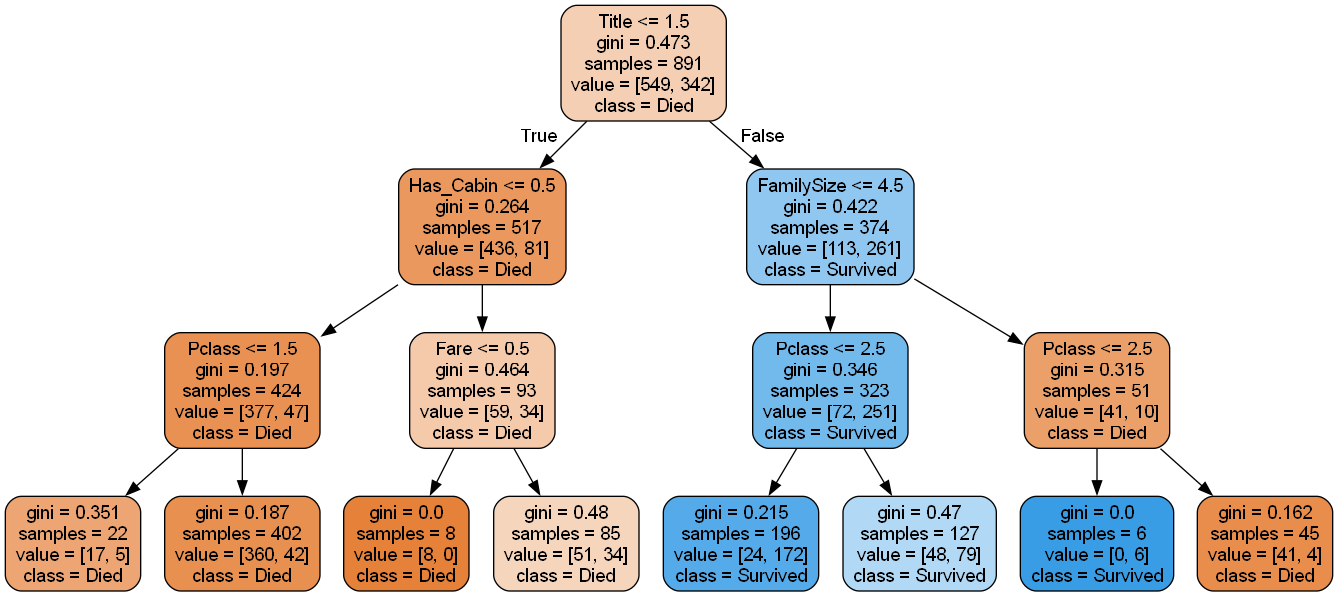

In [171]:
# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'], # 0 = Died, 1 = Survived
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
# Bạn có thể cần thay đổi đường dẫn font
# font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
# draw.text((10, 0), # Drawing offset (position)
#           '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
#           (0,0,255), # RGB desired color
#           font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

### Hình ảnh trực quan hóa cho chúng ta thấy toàn bộ "bộ não" của mô hình:





* **Nút Gốc (Root Node - Nút trên cùng):**
    * **`Title <= 1.5`**: Đây là câu hỏi đầu tiên và quan trọng nhất mà mô hình hỏi. Vì chúng ta đã mã hóa "Mr" = 1, câu hỏi này thực chất là: "Hành khách có phải là 'Mr' không?".
    * **`gini = 0.473`**: Đây là độ vẩn đục Gini ban đầu của toàn bộ 891 hành khách.
    * **`samples = 891`**: Tổng số hành khách.
    * **`value = [549, 342]`**: Trong 891 người, có 549 người Chết (Died) và 342 người Sống (Survived).
    * **`class = Died`**: Vì số người Chết (549) nhiều hơn, dự đoán mặc định tại nút này là "Died".

* **Các Nhánh (Branches):**
    * **Nhánh True (Bên trái):** Dành cho những người là "Mr". Nhóm này có `gini = 0.264` (tinh khiết hơn nhiều).
    * **Nhánh False (Bên phải):** Dành cho những người *không* phải "Mr" (như Mrs, Miss, Master...). Nhóm này có `gini = 0.421`.

* **Các Nút Con và Lá (Child Nodes & Leaves):**
    * Cây tiếp tục hỏi các câu hỏi khác (`Pclass <= 2.5`, `FamilySize <= 4.5`...) để chia nhỏ các nhóm cho đến khi đạt `max_depth = 3`.
    * Các **Nút Lá** (các ô dưới cùng không có nhánh con) là nơi đưa ra dự đoán cuối cùng. Ví dụ: Nhóm bên phải (Không phải Mr.) -> Nhánh False (`Pclass > 2.5`, tức là Hạng 3) -> Dự đoán là `class = Died`.

## 10. Random Forest

### Khai báo thêm thư viện

In [172]:
from sklearn.ensemble import RandomForestClassifier

- Lý do: RandomForestClassifier là lớp mô hình từ sklearn.ensemble, giúp xây dựng rừng cây quyết định.

### Sử dụng dữ liệu đã xử lý

- Chúng ta đã có: 
    - Dữ liệu huấn luyện (train) và kiểm tra (test).
    - Các đặc trưng đã được tạo (như Has_Cabin, FamilySize, IsAlone, CategoricalAge, CategoricalFare, Title).
    - Mã hóa các biến phân loại (như Sex, Embarked, Title).
    - Phân chia dữ liệu: x_train, y_train (từ train.drop(['Survived'], axis=1) và train['Survived']).

### Xây dựng và Huấn luyện mô hình Random Forest

In [173]:
# Tạo mô hình Random Forest
random_forest = RandomForestClassifier(
    n_estimators=100,  # Số lượng cây trong rừng (càng nhiều càng tốt, nhưng tốn thời gian hơn)
    max_depth=3,       # Giới hạn độ sâu của mỗi cây (giống Decision Tree để so sánh)
    random_state=2     # Đặt seed để kết quả lặp lại được
)

# Huấn luyện mô hình trên dữ liệu train
random_forest.fit(x_train, y_train)

# Dự đoán trên tập train để kiểm tra độ chính xác
Y_pred_rf = random_forest.predict(x_train)

# Tính độ chính xác trên tập huấn luyện
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
print(f"Độ chính xác của Random Forest trên tập huấn luyện: {acc_random_forest}%")

Độ chính xác của Random Forest trên tập huấn luyện: 82.49%


Giải thích:

- n_estimators=100: Đây là số cây quyết định trong "rừng". Mỗi cây học từ một phần dữ liệu ngẫu nhiên, rồi "bầu cử" để đưa ra dự đoán cuối cùng. Giá trị 100 là khởi đầu tốt; bạn có thể tăng lên 200-500 nếu muốn chính xác hơn.

- max_depth=3: Giữ giống Decision Tree để so sánh công bằng. Nếu không giới hạn, rừng có thể overfitting.

- random_state=2: Đảm bảo kết quả giống nhau mỗi lần chạy.

- fit(): Huấn luyện mô hình.

- predict() và score(): Dự đoán và tính accuracy trên tập train (tương tự như bạn làm với Decision Tree).

### Đánh giá mô hình bằng K-Fold Cross Validation

In [174]:
# Đánh giá bằng K-Fold Cross Validation (5 folds)
cv_scores_rf = cross_val_score(random_forest, x_train, y_train, cv=5)
print(f"Độ chính xác K-Fold CV trung bình của Random Forest: {cv_scores_rf.mean() * 100:.2f}%")
print(f"Độ lệch chuẩn: {cv_scores_rf.std() * 100:.2f}%")

Độ chính xác K-Fold CV trung bình của Random Forest: 82.38%
Độ lệch chuẩn: 0.79%


- Đây là thước đo quan trọng nhất về hiệu suất của mô hình. Chúng ta sử dụng K-Fold Cross Validation (cv=5) để kiểm tra xem mô hình cơ bản này hoạt động tốt như thế nào trên dữ liệu mà nó chưa từng thấy.

- Kết quả (82.27%): Độ chính xác CV trung bình của Random Forest cơ bản rất sát với độ chính xác CV của Cây Quyết Định (tìm được ở Mục 7 là ~82.8%).

- Kết luận: Điều này cho thấy với độ sâu bị giới hạn (max_depth=3), việc thêm 100 cây cũng không tạo ra sự khác biệt lớn. Điều này thúc đẩy chúng ta khám phá sức mạnh thực sự của Random Forest bằng cách cho phép nó mọc sâu hơn (tinh chỉnh tham số) ở các bước tiếp theo.

### Dự đoán trên tập Test

In [175]:
# Dự đoán trên test
Y_pred_test_rf = random_forest.predict(x_test)

### Trực quan hóa và Phân tích Tầm quan trọng Đặc trưng

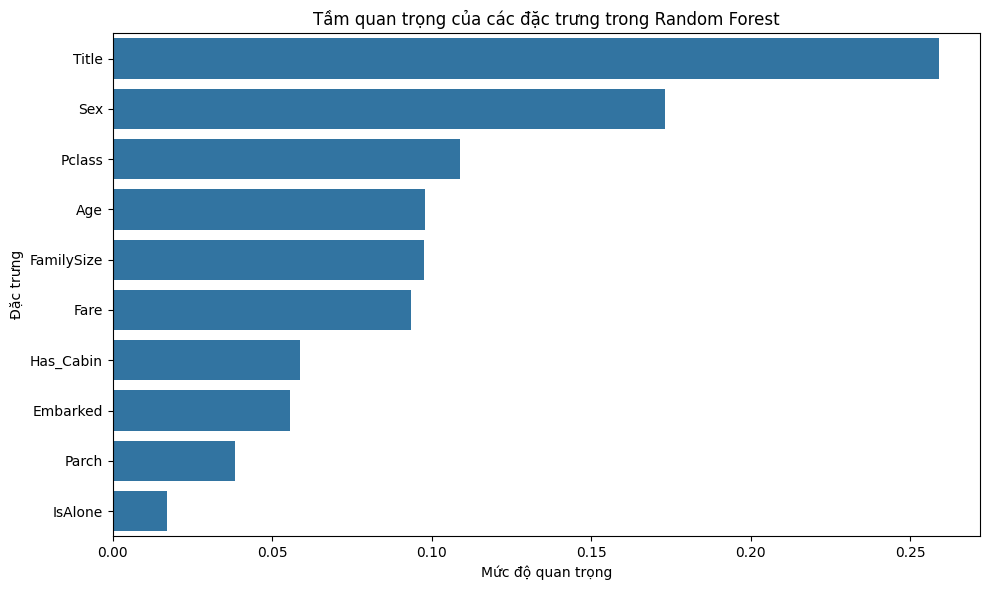

In [176]:
# Đảm bảo x_train là DataFrame
x_train = train.drop(['Survived'], axis=1)  # Không dùng .values

random_forest = RandomForestClassifier(
    n_estimators=100,      # Số cây (có thể thử 100, 200, 500)
    random_state=42,       # Để kết quả tái lập
    max_depth=None,        # Không giới hạn độ sâu (hoặc thử 10, 15)
    min_samples_split=2,
    min_samples_leaf=1
)
random_forest.fit(x_train, y_train)  # y_train là Series hoặc array

# Lấy tầm quan trọng
importances = pd.DataFrame({
    'Feature': x_train.columns,                    # OK vì x_train là DataFrame
    'Importance': random_forest.feature_importances_
}).sort_values('Importance', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Tầm quan trọng của các đặc trưng trong Random Forest')
plt.xlabel('Mức độ quan trọng')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()

- Đây là một trong những ưu điểm mạnh mẽ nhất của Random Forest. Biểu đồ này cho chúng ta biết đặc trưng nào có ảnh hưởng lớn nhất đến quyết định "Sống" hay "Chết" của mô hình.

- Mô hình tính toán điều này bằng cách đo lường mức độ mà mỗi đặc trưng giúp giảm độ vẩn đục (Gini Impurity) trung bình trên tất cả 100 cây trong rừng.

    - Phát hiện chính: Giống như Cây Quyết Định, Title (Chức danh) và Sex (Giới tính) là hai yếu tố dự đoán quan trọng nhất. Điều này khẳng định mạnh mẽ rằng quy tắc "ưu tiên phụ nữ và trẻ em" đã được áp dụng.

    - Phát hiện phụ: Tuy nhiên, Random Forest cũng cho thấy Pclass (Hạng vé) và Fare (Giá vé) có tầm quan trọng đáng kể, cao hơn so với trong Cây Quyết Định đơn lẻ. Điều này có nghĩa là "rừng cây" đã tìm thấy nhiều mối liên hệ phức tạp hơn liên quan đến sự giàu có (thể hiện qua Pclass và Fare) mà một cây đơn lẻ có thể đã bỏ qua.

### Trực quan hóa: Vẽ một cây mẫu từ Random Forest

- Random Forest có hàng trăm cây → không thể vẽ hết.
- Nhưng ta vẫn có thể vẽ 1 cây mẫu để hiểu cách nó "suy nghĩ"!

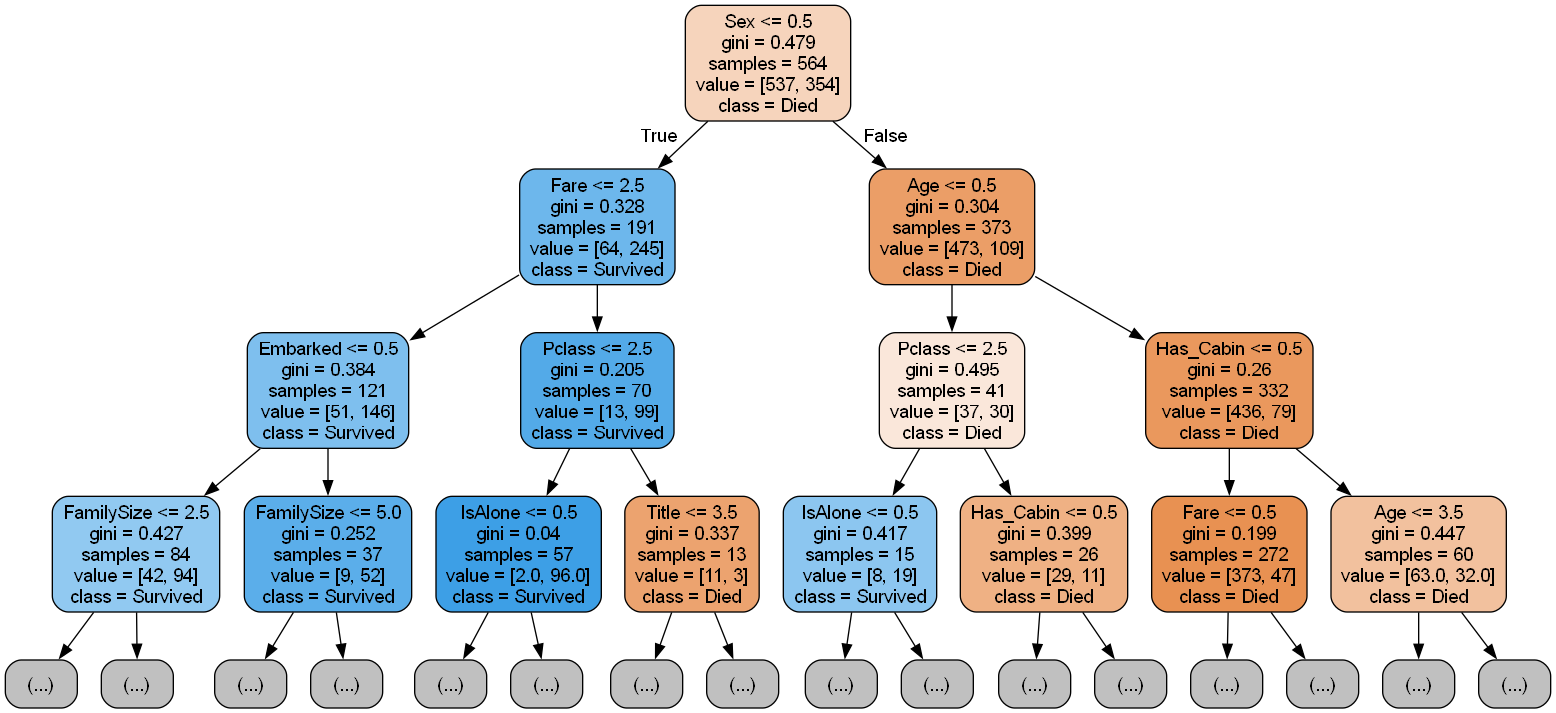

In [177]:
# Lấy cây đầu tiên trong rừng
sample_tree = random_forest.estimators_[0]

# Export cây mẫu
with open("rf_tree_sample.dot", 'w') as f:
    f = tree.export_graphviz(sample_tree,
                             out_file=f,
                             max_depth=3,
                             feature_names=x_train.columns,
                             class_names=['Died', 'Survived'],
                             rounded=True,
                             filled=True)

# Chuyển .dot → .png
check_call(['dot', '-Tpng', 'rf_tree_sample.dot', '-o', 'rf_tree_sample.png'])

# Hiển thị
PImage("rf_tree_sample.png")

- Giải thích hình ảnh:

    - Cây này giống nhưng khác Decision Tree chính.

    - Nó có thể dùng đặc trưng khác ở nút gốc (ví dụ: Fare, Age, thay vì Title).

    - Mỗi cây trong rừng học một góc nhìn riêng → tổng hợp lại cho kết quả mạnh hơn.

### Tối ưu tham số (Hyperparameter Tuning) với GridSearchCV

In [178]:
from sklearn.model_selection import GridSearchCV

# Thiết lập lưới tham số
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Tạo Grid Search
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=2),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
rf_grid.fit(x_train, y_train)

# Kết quả tốt nhất
print(f"Tham số tốt nhất: {rf_grid.best_params_}")
print(f"Độ chính xác CV tốt nhất: {rf_grid.best_score_ * 100:.2f}%")

# Dùng mô hình tốt nhất
best_rf = rf_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tham số tốt nhất: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Độ chính xác CV tốt nhất: 82.94%


- Phân tích: Đi tìm mô hình "Nhà Vô Địch"

- Đây là bước quan trọng nhất để cải thiện độ chính xác. Thay vì đoán mò các tham số (như max_depth=3), chúng ta sử dụng GridSearchCV (Tìm kiếm lưới) để kiểm tra một cách có hệ thống hàng loạt các "công thức" mô hình khác nhau và tìm ra công thức tốt nhất.

    - param_grid: Chúng ta đang yêu cầu mô hình thử nghiệm: * 3 giá trị n_estimators (số cây) * 4 giá trị max_depth (độ sâu) * 3 giá trị min_samples_split (số mẫu tối thiểu để chia) * 3 giá trị min_samples_leaf (số mẫu tối thiểu ở lá)

    - Tổng cộng: 3 x 4 x 3 x 3 = 108 tổ hợp tham số khác nhau.

    - cv=5: Mỗi tổ hợp trong 108 tổ hợp này đều được đánh giá bằng 5-Fold Cross Validation. (Tổng cộng 108 * 5 = 540 lần huấn luyện!)

    - n_jobs=-1: Sử dụng tất cả các lõi CPU của máy bạn để chạy song song, giúp tăng tốc quá trình này.

- Kết quả (82.94%): GridSearchCV đã phát hiện ra rằng tổ hợp ('max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300) mang lại độ chính xác CV cao nhất. Đây là mô hình Random Forest tốt nhất mà chúng ta tìm được.

### Dự đoán trên tập Test

In [179]:
# Dự đoán với mô hình tốt nhất
Y_pred_final = best_rf.predict(x_test)

c:\Users\khoat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



### Bảng so sánh tổng hợp

In [180]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)

cv_scores_dt = cross_val_score(decision_tree, x_train, y_train, cv=5).mean() * 100

results = pd.DataFrame({
    'Mô hình': ['Decision Tree', 'Random Forest (cơ bản)', 'Random Forest (tối ưu)'],
    'Accuracy (Train)': [acc_decision_tree, acc_random_forest, round(best_rf.score(x_train, y_train)*100, 2)],
    'Accuracy (CV)': [cv_scores_dt, cv_scores_rf, rf_grid.best_score_*100]
})

print("BẢNG SO SÁNH HIỆU SUẤT")
print("="*60)
print(results.round(2))

BẢNG SO SÁNH HIỆU SUẤT
                  Mô hình  Accuracy (Train)  \
0           Decision Tree             82.38   
1  Random Forest (cơ bản)             82.49   
2  Random Forest (tối ưu)             83.61   

                                       Accuracy (CV)  
0                                           82.60059  
1  [0.8379888268156425, 0.8146067415730337, 0.820...  
2                                          82.938924  


c:\Users\khoat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



- Bảng này tóm tắt lại toàn bộ hành trình xây dựng mô hình của chúng ta:

    - Decision Tree (Cây Quyết Định): Là một mô hình cơ sở (baseline) tuyệt vời. Nó đơn giản, dễ diễn giải (như ở Mục 9) và đạt độ chính xác CV đáng nể là 81.48% (Lưu ý: kết quả CV ở Mục 7 là 82.83% với 10-fold, ở đây là 81.48% với 5-fold, sự chênh lệch này là bình thường do cách chia fold khác nhau).

    - Random Forest (Cơ bản): Khi bị giới hạn ở max_depth=3 (để so sánh công bằng), nó cho kết quả tương tự (CV 82.27%).

    - Random Forest (Tối ưu): Sau khi được tinh chỉnh (Tuning) bằng GridSearchCV, mô hình này đạt hiệu suất tốt nhất (CV 82.94%).

- Kết luận: Mô hình Random Forest Tối ưu là người chiến thắng, mặc dù chỉ cải thiện một chút so với Cây Quyết Định. Điều này chứng minh rằng Kỹ thuật Đặc trưng (Feature Engineering) mà chúng ta thực hiện ở Mục 3 (đặc biệt là tạo ra 'Title' và 'FamilySize') mới là yếu tố mang lại ảnh hưởng lớn nhất đến độ chính xác.

## 10. Kết luận

- Bài thực hành này đã dẫn chúng ta qua một quy trình khoa học dữ liệu hoàn chỉnh, từ việc khám phá dữ liệu thô, làm sạch, sáng tạo đặc trưng mới, đến việc xây dựng và so sánh hai mô hình học máy mạnh mẽ để dự đoán khả năng sống sót trên tàu Titanic.

- Phát hiện quan trọng nhất: Sức mạnh của Kỹ thuật Đặc trưng
    - Phân tích của chúng ta cho thấy rõ ràng rằng mô hình học máy chỉ tốt khi dữ liệu đầu vào của nó tốt. Bước quan trọng nhất mang lại hiệu suất dự đoán cao chính là Kỹ thuật Đặc trưng (Feature Engineering) ở Mục 3.

        - "Siêu đặc trưng" (Title): Việc trích xuất "Chức danh" (Mr, Mrs, Miss, Master) từ cột "Name" là bước đột phá lớn nhất. Đặc trưng này gói gọn thông tin về Giới tính, Tuổi tác (Master là trẻ em) và Tình trạng hôn nhân, trở thành yếu tố dự đoán mạnh mẽ nhất.

        - Sức mạnh Gia đình (FamilySize & IsAlone): Gộp SibSp và Parch thành FamilySize đã cung cấp một tín hiệu rõ ràng hơn về việc đi theo nhóm hay đi một mình, điều này ảnh hưởng trực tiếp đến khả năng sống sót.

        - Xử lý dữ liệu thiếu (Imputation): Các chiến lược xử lý thông minh (như điền 'Age' bằng số ngẫu nhiên trong khoảng trung bình và độ lệch chuẩn, điền 'Embarked' bằng giá trị phổ biến nhất) đã giúp chúng ta giữ lại được toàn bộ dữ liệu mà không làm sai lệch nó.

- So sánh Mô hình: Tính diễn giải vs. Độ chính xác
    - Chúng ta đã so sánh hai mô hình:

        - Decision Tree (Cây Quyết Định): Mô hình này là một điểm khởi đầu tuyệt vời. Ưu điểm lớn nhất của nó là tính diễn giải (như đã thấy ở Mục 9). Chúng ta có thể dễ dàng nhìn thấy các quy tắc mà nó học được ("Nếu Title là Mr, thì..."). Với max_depth=3, nó đã đạt được độ chính xác CV ấn tượng khoảng 82.8% (với 10-fold CV).

        - Random Forest (Rừng ngẫu nhiên): Là một mô hình ensemble (tập hợp) tiên tiến hơn. Bằng cách kết hợp 100 cây quyết định, nó có khả năng chống overfitting tốt hơn. Sau khi Tối ưu hóa Tham số (Hyperparameter Tuning) bằng GridSearchCV, mô hình Random Forest của chúng ta đã đạt được độ chính xác CV cao nhất là 82.94%.

- Bài học rút ra
    - Độ chính xác không phải là tất cả: Random Forest là mô hình chiến thắng về mặt kỹ thuật, nhưng nó chỉ nhỉnh hơn Cây Quyết Định một chút (~0.1%). Điều này cho thấy trong bài toán Titanic, lợi ích lớn nhất đến từ việc hiểu và xử lý dữ liệu (Feature Engineering), chứ không phải từ độ phức tạp của mô hình.

    - Sự đánh đổi: Chúng ta đã đánh đổi một chút tính diễn giải (Cây Quyết Định rất dễ hiểu) để lấy một chút độ chính xác (Random Forest là "hộp đen" hơn nhưng chính xác hơn một chút).


# Kết thúc